In [79]:

import jax.numpy as jnp

import sys

sys.path.append("../../siegel_analyses/scripts/")
sys.path.insert(1,'../scripts/')

import netrep_helpers as nh
import utils
import loader
import setup
import matplotlib.pyplot as plt

import seaborn as sns
%load_ext autoreload
%autoreload 2
import scipy.stats as sts
import numpy as np

import imp
imp.reload(setup)
imp.reload(loader)
imp.reload(utils)
import tqdm
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
#load data 
# with(open("100_avg_folds_response_aligned.pkl","rb")) as f:
#     import pickle
#     params,_ys,train_data_folds_time,test_data_folds_time = pickle.load(f)

import pickle
with(open("raw_behavior.pkl","rb")) as f:    
    cs_trials = pickle.load(f)

"""
with(open("prep_data/raw_behavior.pkl","rb")) as f:    
    cs_trials = pickle.load(f)
"""


'\nwith(open("prep_data/raw_behavior.pkl","rb")) as f:    \n    cs_trials = pickle.load(f)\n'

In [81]:
valid = [1, 2, 3, 4, 8, 10, 13, 14, 15, 16, 19, 21, 22, 23, 24, 25, 26, 29, 31, 32]


In [82]:
def convert_to_rw_choices(cs_trials):
    choices = []
    for subject in cs_trials:
        left = subject[:,:4] == -1
        right = subject[:,5:] == 1
        both = np.column_stack([left.astype(int), right.astype(int)])
        choices.append(np.mean(both,0))
    return np.array(choices)

In [83]:

def get_dists(train_fold,test_fold):

    ys,cs = train_fold
    _,cs = test_fold

    S = len(ys)

    #compute distance matrices
    dist_neural = utils.dsd([
        [ys[i],ys[j]]
        for i in range(len(ys)) 
        for j in range(len(ys))]
    ).reshape(S,S)


    dist_cc = np.zeros((S,S))

    for i in range(S):
        for j in range(S):
            dist_cc[i,j] = np.mean(np.abs(cs[i]- cs[j]))

    return dist_neural,dist_cc,cs



def get_kneigh_decreasing(dist_neural,cs,S=10,W=2):
    """
    Compute the correlation between each subject behavior and average of the top K=2 neighbors in neural space
    cs: list of behavioral functions for each subject
    dist_neural: distance matrix between subjects in neural space
    S: number of subjects
    W: number of neighbors to consider
    returns all_preds_top: (19, 20) S - 1 x S
    """


    avg_cc = np.array(cs) #np.array([np.mean(c,0) for c in cs])
    all_preds_top = []

    for K in range(W,S+1):
        preds_top = []
        for subj in range(S):
            subj_idx =list(range(S))

            #ignore itself
            subj_idx.remove(subj)
            subj_idx = np.array(subj_idx)

            dists = dist_neural[subj][subj_idx] 
            sorted_idx  = subj_idx[np.argsort(dists)]

            s_dists=np.sort(dists)

            weights_top = np.exp(-s_dists[K-W:K])

            top_k = avg_cc[sorted_idx[K-W:K]] 
        
            preds_top.append(sts.pearsonr(np.mean(top_k,0),avg_cc[subj])[0])

        all_preds_top.append(preds_top)

    all_preds_top = np.array(all_preds_top)
    return all_preds_top

In [84]:

import pickle

with open("100_folds_1_time_point.pkl","rb") as f:
    [params,train_data_folds,test_data_folds] = pickle.load(f)

In [85]:

import pickle

with open("prep_data/100_folds_1_time_point.pkl","rb") as f:
    [params_prep,train_data_folds_prep,test_data_folds_prep] = pickle.load(f)

In [95]:

n_folds = 100
n_shuffles = 500


all_c_corrs = []
all_zscores = []
all_preds_top = []
neurons_test = []

all_dist_neural = []
all_dist_cc = []

for fold in tqdm.trange(n_folds):
    train_fold, test_fold = train_data_folds[fold], test_data_folds[fold]
    neuron_fold = []
    for fold in test_fold[0]:
        neuron_fold.append(len(fold[0]))
    neurons_test.append(neuron_fold)
    
    try: 
        dist_neural,dist_cc,cs = get_dists(train_fold,test_fold)
    except np.linalg.LinAlgError:
        print("linalg error")
        continue
    
    all_dist_neural.append(dist_neural)
    all_dist_cc.append(dist_cc)
    
    S = dist_neural.shape[0]
    flat_dist_neural = dist_neural[jnp.triu_indices(S,1)]
    flat_dist_cc = dist_cc[jnp.triu_indices(S,1)]

    r,_ = sts.pearsonr(flat_dist_cc,flat_dist_neural)
    preds_top = get_kneigh_decreasing(dist_neural,cs,S)
    all_preds_top.append(preds_top)

    # compute shuffled correlation
    corrs_shuffle = []
    flat_dist_cc_s =flat_dist_cc.copy()
    for _ in range(n_shuffles):
        np.random.shuffle(flat_dist_cc_s)
        r_s,_ = sts.pearsonr(flat_dist_cc_s,flat_dist_neural)
        corrs_shuffle.append(r_s)

    # save z-scored correlation
    all_zscores.append((r - np.mean(corrs_shuffle))/np.std(corrs_shuffle))
    all_c_corrs.append([r,corrs_shuffle])



all_dist_neural = np.array(all_dist_neural)
all_dist_cc = np.array(all_dist_cc)
all_zscores = np.array(all_zscores)

100%|██████████| 100/100 [01:45<00:00,  1.06s/it]


In [97]:
neurons_test = np.array(neurons_test, dtype=int)

In [98]:
np.savetxt("neurons_test.csv",neurons_test,delimiter=",",fmt="%d",)


In [89]:
# data_corrs = np.array(all_c_corrs)[:,0]
data_corrs = np.array(all_c_corrs, dtype=object)[:,0]

dist_neural = all_dist_neural[np.argmax(data_corrs)].copy()
dist_cc = all_dist_cc[np.argmax(data_corrs)].copy()

# for plotting
dist_neural_ = dist_neural.copy()
dist_cc_ = dist_cc.copy()
dist_neural_[np.triu_indices(dist_neural.shape[0],0)] = np.nan
dist_cc_[np.tril_indices(dist_neural.shape[0],0)] = np.nan

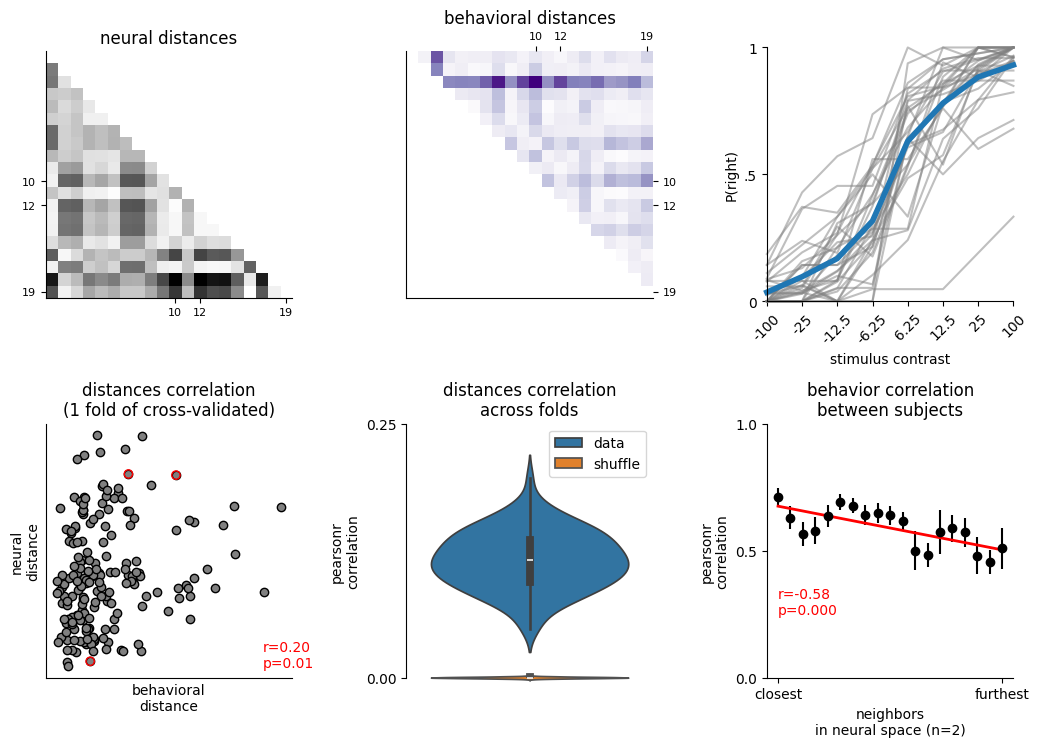

In [93]:
examples_idx= [10,12,19]
colors = np.array(sns.color_palette(None, S))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(7*1.5,5*1.5))

### DISTANCE MATRICES
axes = axes.flatten()
axes[0].set_title('neural distances')
axes[0].imshow(dist_neural_,cmap="Grays")
axes[0].set_xticks(examples_idx)
axes[0].set_yticks(examples_idx)
#cbar = plt.colorbar(axes[0].imshow(dist_neural_,cmap="Grays"),ax=axes[0],shrink=0.5,orientation="horizontal")


axes[1].set_title('behavioral distances')
axes[1].imshow(dist_cc_,cmap="Purples")
axes[1].set_xticks(examples_idx)
axes[1].set_yticks(examples_idx)
axes[1].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False,left=False,labelleft=False,right=True,labelright=True)
#plt.colorbar(axes[1].imshow(dist_cc_,cmap="Purples"),ax=axes[1],shrink=0.5,orientation="horizontal")

#change ticks fontsize
for ti,tick in enumerate(axes[0].get_xticklabels()):
    tick.set_fontsize(8)
    axes[0].get_yticklabels()[ti].set_fontsize(8)
    axes[1].get_xticklabels()[ti].set_fontsize(8)
    axes[1].get_yticklabels()[ti].set_fontsize(8)


### PSYCHOMETRIC CURVES
contrast = [-100.  ,  -25.  ,  -12.5 ,   -6.25,    0.  ,    6.25,   12.5 ,
         25.  ,  100.  ]

avg_cc = [np.mean(c==1,0) for c in cs_trials]

####
### previous version of example subjects
####
# for si,subj in enumerate(examples_idx):

#     axes[2].plot(range(9),avg_cc[subj],label="#%i" % subj,color=colors[subj],clip_on=False) 
#     axes[2].scatter(range(9),avg_cc[subj],edgecolors=colors[subj], s=50, facecolors='white', zorder=3,clip_on=False) 

# axes[2].set_ylabel("P(correct)")
# axes[2].set_xlabel("contrast")
# axes[2].legend(title="subject",ncols=2)
# axes[2].plot([4,4],[0,1],"--",color="gray")
# axes[2].plot([0,9],[0.5,0.5],"--",color="gray")
# axes[2].set_yticks([0,0.5,1],[0,'.5',1])
# axes[2].set_ylim(0,1)
# axes[2].set_xticks(range(len(contrast)),[-100,-25,-12.5,-6.25,0,6.25,12.5,25,100],rotation=45)

choices = convert_to_rw_choices(cs_trials)
axes[2].plot(choices.T, color='gray', alpha=0.5,clip_on=False)
axes[2].plot(np.mean(choices,0), lw=4,clip_on=False)   
axes[2].set_ylabel("P(right)")
axes[2].set_xlabel("stimulus contrast")
axes[2].set_xticks(range(len(contrast)-1),[-100,-25,-12.5,-6.25,6.25,12.5,25,100],rotation=45)
axes[2].set_yticks([0,0.5,1],[0,'.5',1])
axes[2].set_ylim(0,1)
axes[2].set_xlim(0,7)

# take upper triangle
flat_dist_neural = dist_neural[jnp.triu_indices(S,1)]
flat_dist_cc = dist_cc[jnp.triu_indices(S,1)]

r,p = sts.pearsonr(flat_dist_cc,flat_dist_neural)
axes[3].scatter( flat_dist_cc,flat_dist_neural,color="k",facecolors='gray')
axes[3].text(1,0.1,"r={:.2f}\np={:.2f}".format(r,p),color="red")
axes[3].set_xlabel("behavioral\ndistance")
axes[3].set_ylabel("neural\ndistance")
axes[3].set_xticks([])
axes[3].set_yticks([])
axes[3].set_title("distances correlation\n(1 fold of cross-validated)")
axes[3].scatter(dist_cc[examples_idx,:][:,examples_idx][np.triu_indices(len(examples_idx),1)].flatten(),
                dist_neural[examples_idx,:][:,examples_idx][np.triu_indices(len(examples_idx),1)].flatten(),facecolors='none', edgecolors='red',zorder=10)

####
### previous version of Z-scored correlations
####

# axes[4].hist(all_zscores,color="black",bins=20)
# axes[4].set_xlim(0,4)
# plt.xlim(0,4)
# axes[4].set_ylim(0,10)

# axes[4].set_yticks([0,5,10],['0','','10'])
# axes[4].set_xlabel("z-score")
# asymmetric_error = np.array([[np.mean(all_zscores) - np.percentile(all_zscores,2.5),np.percentile(all_zscores,97.5) - np.mean(all_zscores)]])
# axes[4].errorbar(np.mean(all_zscores),0.75,xerr=asymmetric_error.T,color="red",label="95% CI")
# axes[4].plot(np.mean(all_zscores),0.75,"o",color="red")
# axes[4].legend()

axes[4].set_title("distances correlation\nacross folds")

#data_corrs = np.array(all_c_corrs)[:,0]
data_corrs = np.array(all_c_corrs, dtype=object)[:,0]

shuffle_corrs = np.array(all_c_corrs, dtype=object)[:,1].mean()
#shuffle_corrs = np.array(all_c_corrs)[:,1].mean()

sns.violinplot(data_corrs,label="data",ax=axes[4])
sns.violinplot(shuffle_corrs,label="shuffle",ax=axes[4],clip_on=False)
axes[4].legend()
axes[4].set_ylabel("pearsonr\ncorrelation")
axes[4].set_yticks([0,0.25])
axes[4].set_ylim(0,0.25)
axes[4].set_xticks([])


_ids = list(range(S-1))*np.shape(all_preds_top)[0]

r=sts.linregress(_ids,np.mean(all_preds_top,2).reshape(-1))

#axes[5].plot(np.mean(all_preds_top,2).T,"k.",alpha=0.1,clip_on=False)
plt.errorbar(range(19),np.mean(np.mean(all_preds_top,2),0),np.std(np.mean(all_preds_top,2),0),fmt='o',color='black',clip_on=False)
#axes[5].plot(np.mean(all_preds_top,2).mean(0),"r-",lw=2)
axes[5].set_title("behavior correlation\nbetween subjects")

axes[5].text(0,0.25,"r={:.2f}\np={:.3f}".format(r.rvalue,r.pvalue),color='r')  
axes[5].set_ylabel("pearsonr\ncorrelation")
axes[5].set_yticks([0,0.5,1])
#axes[5].set_xticks([0,(S-2)//2,S-2],["closest","[%i,%i]" % ((S-2)//2,(S-2)//2+1),"[%i,%i]" % (S-2,S-1)])
axes[5].set_xticks([0,S-2],["closest","furthest"])

axes[5].set_xlabel("neighbors\nin neural space (n=2)")
#axes[5].hlines(y=0.8, xmin=0, xmax=18, colors='black',lw=0.5)
axes[5].set_ylim(0,1)
#axes[5].text(9,.95,"*",color='black')
# plot regression line on top of the data using the slope and intercept
axes[5].plot(range(19)*r.slope+r.intercept,"r-",lw=2)

fig.tight_layout()
sns.despine()
sns.despine(ax=axes[4],bottom=True)



plt.savefig("IBL_main_figure.svg",dpi=300)

#plt.savefig("../results/IBL_main_figure.svg",dpi=300)

In [96]:
sts.ttest_rel(np.mean(all_preds_top,0)[0],np.mean(all_preds_top,0)[-1])

TtestResult(statistic=np.float64(2.1528029033085145), pvalue=np.float64(0.044395191046249866), df=np.int64(19))

<Figure size 70x375 with 0 Axes>

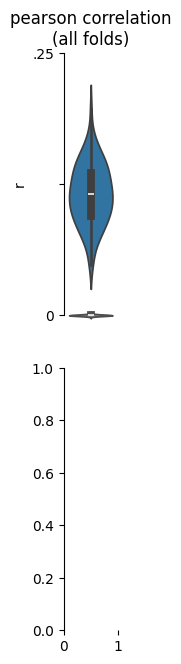

In [ ]:


plt.figure(figsize=(7*1.5/15,5*1.5/2))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7*1.5/15,5*1.5))
axes = axes.flatten()
axes[0].set_title("pearson correlation\n(all folds)")

sns.violinplot(data_corrs,label="data",ax=axes[0])
sns.violinplot(shuffle_corrs,label="shuffle",clip_on=False,color="gray",ax=axes[0])
axes[0].set_ylabel("r")
axes[0].set_yticks([0,0.25/2,0.25],[0,'','.25'])
axes[0].set_ylim(0,0.25)
axes[0].set_xticks([])
sns.despine(bottom=True)

plt.savefig("violinplot.svg",dpi=300)

#plt.savefig("../results/violinplot.svg",dpi=300)